# Foundations Of AIML
## Session 11
### Experiment 1.2: Momentum

The objective of this experiment is to tune the hyper parameter called momentum and observe the output differences.

We will use CIFAR100 dataset.This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 50,000 training images and 10,000 testing images. 

**Importing required packages**

In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [0]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0

#### Preparing the dataset

In [0]:
print('\n[Phase 1] : Data Preparation')

##dataset
dataset = 'cifar100'

# Preparing the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
]) # meanstd transformation


[Phase 1] : Data Preparation


#### Applying the standard mean

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
])

#### Downloading and Loading the dataset

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.


In [0]:
# number of classes in the dataset
num_classes = 100

In [0]:
### Downloading the dataset
trainset = torchvision.datasets.CIFAR100(root='/data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='/data', train=False, download=False, transform=transform_test)
### Loading the dataset 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)


Files already downloaded and verified


#### Let us define the network

In [0]:
import torch.nn as nn
import torch.nn.functional as F

        
class LeNet(nn.Module):
    def __init__(self, num_classes, init_mode='xavier'):  ### supports 'zero', 'normal', 'xavier', 'he' inits
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
        if init_mode == 'zero':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.zero_()   ### fill tensor elements with zeros
                    if m.bias is not None:
                        m.bias.data.zero_()
        
        if init_mode == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.normal_()   ### fill tensor elements with random numbers from normal distribution
                    if m.bias is not None:
                        m.bias.data.normal_()
        
        if init_mode == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                    n = fan_in + fan_out
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in+fan_out))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
        
        if init_mode == 'he':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
                
                
    ## Forward Pass
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return(out)

### Training with Xavier init

In [0]:
## Calling the model
net = LeNet(num_classes, init_mode='xavier')
## Checking for GPU instance 
if use_cuda:
    net.cuda()

In [0]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    # Declaring the Variables
    train_loss = 0
    correct = 0
    total = 0
    # Loopiing over train data
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Checking for GPU instance
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # Optimizer
        optimizer.zero_grad()
        # Converting inputs and targets into pytorch variables
        #inputs, targets = Variable(inputs), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        # Storing the outputs size
        size_ = outputs.size()
        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Backward Pass
        loss.backward()
        # Optimizer steps
        optimizer.step()
        ## Calculating the traqin loss
        #train_loss += loss.data[0]
        train_loss += loss.item()
        # Predicting the values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the targets size
        total += targets.size(0)
        # Calculating the corrected values
        correct += predicted.eq(targets.data).cpu().sum()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Storing number of epoch, loss and accuracy in a file
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [0]:
def test(epoch):
    global best_acc
    net.eval()
    # Declaring the variables
    test_loss = 0
    correct = 0
    total = 0
    # Looping over the test data
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # Checking for GPU instance
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        ## Coverting inputs and targets intp pytorch variables
        #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        # Forward pass
        outputs = net(inputs)
        # Storing the size of outputs
        size_ = outputs.size()
        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Calculating the test loss
        #test_loss += loss.data[0]
        test_loss += loss.item()
        # Predicted values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the size of targets
        total += targets.size(0)
        # Calculating the correct values
        correct += predicted.eq(targets.data).cpu().sum()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            # printing the progress bar
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Printing the validation loss 
    print('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    # Storing number of epoch,loss and acuracy in a file
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    # Checking for best accuracy
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net,
            'acc': acc,
            'epoch': epoch,
        }
        # Checking for the directory
        if not os.path.isdir('../checkpoint'):
            # creating the directory
            os.mkdir('../checkpoint')
        # saving the data
        torch.save(state, '../checkpoint_ckpt.t7')
        # Storing the accuracy value
        best_acc = acc

### Training witout momentum

In [0]:
experiment = 'no_momentum'
# Creating files in write mode
train_loss_file = open("./"+experiment+"train_loss.txt", "w")
val_loss_file = open("./"+experiment+"val_loss.txt", "w")

In [0]:
# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
# Training and Testing the model for 30 epochs
for epoch in range(0, 30):
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
# Closing the values   
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.607 | Acc: 1.000% (717/50000)   391/391 
 [==================================>] | Loss: 4.593 | Acc: 1.000% (178/10000)   100/100 
val_loss:  4.593207092285156 accuracy:  tensor(1)
Saving..


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch: 1
 [==================================>] | Loss: 4.566 | Acc: 2.000% (1003/50000)  391/391 
 [==================================>] | Loss: 4.522 | Acc: 2.000% (222/10000)   100/100 
val_loss:  4.52185025215149 accuracy:  tensor(2)
Saving..

Epoch: 2
 [==================================>] | Loss: 4.464 | Acc: 3.000% (1587/50000)  391/391 
 [==================================>] | Loss: 4.382 | Acc: 4.000% (407/10000)   100/100 
val_loss:  4.381822643280029 accuracy:  tensor(4)
Saving..


#### Plotting the Training curves

3 3


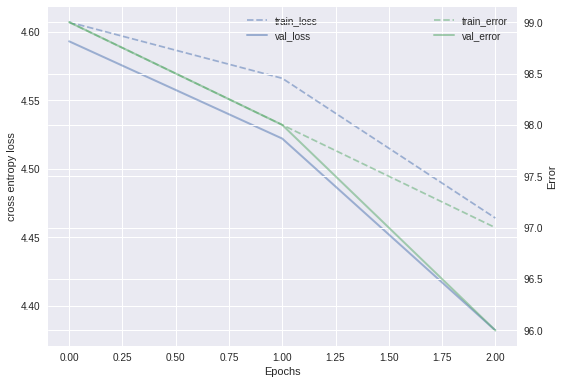

In [0]:
training_curves("./"+experiment)

### Training with momentum

#### Note that momentum is 0 by default in pytorch

In [0]:
best_acc = 0
# Calling the model
net = LeNet(num_classes, init_mode='xavier')
# Checking for GPU instance
if use_cuda:
    net.cuda()

In [0]:
experiment = 'with_momentum'
# Cretaing files in write mode
train_loss_file = open("./"+experiment+"train_loss.txt", "w")
val_loss_file = open("./"+experiment+"val_loss.txt", "w")

In [0]:
# Optimizer 
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# Training and Testing the model for 30 epochs
for epoch in range(0, 30):
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
# Closing the files
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.131 | Acc: 6.000% (3447/50000)  391/391 
 [==================================>] | Loss: 3.861 | Acc: 10.000% (1038/10000) 100/100 
val_loss:  3.860531377792358 accuracy:  tensor(10)
Saving..


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch: 1
 [==================================>] | Loss: 3.773 | Acc: 11.000% (5950/50000) 391/391 
 [==================================>] | Loss: 3.577 | Acc: 14.000% (1476/10000) 100/100 
val_loss:  3.576533012390137 accuracy:  tensor(14)
Saving..

Epoch: 2
 [==================================>] | Loss: 3.588 | Acc: 14.000% (7388/50000) 391/391 
 [==================================>] | Loss: 3.392 | Acc: 17.000% (1795/10000) 100/100 
val_loss:  3.3922096252441407 accuracy:  tensor(17)
Saving..


#### Plotting the training curves

3 3


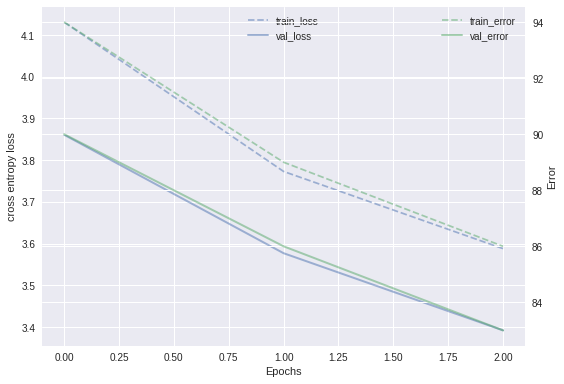

In [0]:
training_curves("./"+experiment)

#### Exercise: Compare with momentum rate of 0.99? How does this compare with momentum rate of 0.5?